In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec

import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/MAXI_J1848m015/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/MAXI_J1848m015/'
    
plot_dir = root_dir + 'figures/'
    
quantiles = np.array([0.05, 0.5, 0.95])
burn = int(1e5)

/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/hendrics/io.py:24: UserWarning: Warning! NetCDF is not available. Using pickle format.
  warnings.warn(msg)


Working on Macbook


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/pulse/accelsearch.py:24: UserWarning: Using standard numpy fft
  warnings.warn("Using standard numpy fft")


# Joint fits

In [36]:
OBSID='90601340002'

products_dir = root_dir + OBSID + '_products06/'

In [37]:
chain_hdu = fits.open(products_dir + 'tbabs_diskbb_relxillNS_nthcomp_cutoffpl_relxilllp_gauss_chain.out')
chain_hdu[1].data

FITS_rec([(4.13461437, 6.748284 , 0.00017704, 6.49944616, 0.96351486, 26.23375552, -1.6638385 , 1.39307982, 2.60822059, 15.00369978, -0.61513862, 2.44030748, 0.00974964, 1.1073995 , 6.1697916 , 6.31963619, 6.29221348e-05, 0.02115508, 5.62344853, 7.95103759, 1.57584019, 2.78316007, 0.77268493, 29.06161949, -0.82786779, 1.04581976, 834.0249871 ),
          (4.13461437, 6.748284 , 0.00017704, 6.49944616, 0.96351486, 26.23375552, -1.6638385 , 1.39307982, 2.60822059, 15.00369978, -0.61513862, 2.44030748, 0.00974964, 1.1073995 , 6.1697916 , 6.31963619, 6.29221348e-05, 0.02115508, 5.62344853, 7.95103759, 1.57584019, 2.78316007, 0.77268493, 29.06161949, -0.82786779, 1.04581976, 834.0249871 ),
          (4.13461437, 6.748284 , 0.00017704, 6.49944616, 0.96351486, 26.23375552, -1.6638385 , 1.39307982, 2.60822059, 15.00369978, -0.61513862, 2.44030748, 0.00974964, 1.1073995 , 6.1697916 , 6.31963619, 6.29221348e-05, 0.02115508, 5.62344853, 7.95103759, 1.57584019, 2.78316007, 0.77268493, 29.06161949,

('nH__2', 'LineE__3', 'norm__5', 'norm__7', 'a__11', 'Incl__12', 'Rin__13', 'kTbb__16', 'logxi__17', 'logN__19', 'refl_frac__20', 'Gamma__22', 'norm__27', 'factor__44', 'nH__88', 'LineE__89', 'norm__91', 'norm__116', 'h__117', 'Rin__120', 'gamma__123', 'logxi__124', 'Afe__125', 'Ecut__126', 'refl_frac__127', 'factor__130', 'FIT_STATISTIC')


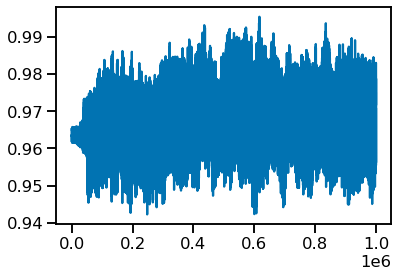

In [31]:
plt.plot(range(len(chain_hdu[1].data['a__11'])), chain_hdu[1].data['a__11'])
print(chain_hdu[1].data.dtype.names)

In [32]:
Z1 = 1.0 + np.power(1.0-np.square(chain_hdu[1].data['a__11']), 1/3)*(np.power(1.0+chain_hdu[1].data['a__11'], 1/3) + np.power(1.0-chain_hdu[1].data['a__11'], 1/3))
Z2 = np.sqrt(3.0*np.square(chain_hdu[1].data['a__11']) + np.square(Z1))
soft_rg = -chain_hdu[1].data['Rin__13']*(3.0 + Z2 - np.sqrt((3.0-Z1)*(3.0 + Z1 + 2.0*Z2)))
# hard_isco = chain_hdu[1].data['Rin__111']/(3.0 + Z2 - np.sqrt((3.0-Z1)*(3.0 + Z1 + 2.0*Z2)))

skip = ['norm__5', 'LineE__3', 'norm__5', 'norm__7', 'logN__19', 'Gamma__22', 'norm__27', 'factor__44', 'LineE__89', 'norm__91', 'norm__116', 'gamma__123', 'Ecut__126', 'factor__130', 'FIT_STATISTIC']

corner_data = []
mean = []
for x in chain_hdu[1].data.dtype.names:
#     if x not in skip:
    if x == 'Rin__13':
        corner_data.append(soft_rg[burn:])
        mean.append(np.mean(soft_rg[burn:]))
        param_err = np.percentile(soft_rg[burn:], q=quantiles*100).T
    else:
        corner_data.append(chain_hdu[1].data[x][burn:])
        mean.append(np.mean(chain_hdu[1].data[x][burn:]))
        param_err = np.percentile(chain_hdu[1].data[x][burn:], q=quantiles*100).T
    
    print(x + ' = ' + str(round(param_err[1], 8)) + ' + ' + str(round(param_err[2] - param_err[1], 8)) + ' - ' + str(round(param_err[1] - param_err[0], 8)))


        
corner_data = np.array(corner_data)
mean = np.array(mean)

    
corner_labels=np.array([r'$n_\mathrm{H,\,soft}\,(\mathrm{cm^{-2}})$', r'$a$', r'$i\,(^{\circ})$', r'$R_{\mathrm{in,\,soft}}\,(R_\mathrm{g})$', r'$kT_\mathrm{bb}\,(\mathrm{keV})$', r'$\log{\xi}_\mathrm{soft}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$f_\mathrm{refl,\,soft}$', \
               r'$n_\mathrm{H,\,hard}\,(\mathrm{cm^{-2}})$', r'$h\,(R_\mathrm{g})$', r'$R_{\mathrm{in,\,hard}}\ (R_\mathrm{g})$', r'$\log{\xi}_\mathrm{hard}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$A_\mathrm{Fe}\,(\mathrm{Solar})$', r'$f_\mathrm{refl,\,hard}$'])

corner_order = [1,2,11,0,3,4,5,6,7,8,9,10,12]
# print(mean)
# param_err = np.percentile(corner_data.T, q=quantiles*100, axis=0).T
# for i in range(len(param_err)):
#     print(str(round(param_err[i,1], 4)) + ' + ' + str(round(param_err[i,2] - param_err[i,1], 4)) + ' - ' + str(round(param_err[i,1] - param_err[i,0], 4)))
# print(param_err)
# figure = corner.corner(corner_data[corner_order].T, quantiles=quantiles, labels=corner_labels[corner_order], labelpad=0.2, verbose=False, show_titles=False)
plt.savefig(plot_dir + 'joint_corner_poster.pdf', bbox_inches='tight')

nH__2 = 4.16185845 + 0.1617825 - 0.13552354
LineE__3 = 6.76949562 + 0.09678172 - 0.1072023
norm__5 = 0.00017651 + 3.88e-06 - 4.26e-06
norm__7 = 6.41374766 + 0.2353432 - 0.26992486
a__11 = 0.96748431 + 0.01294482 - 0.01263049
Incl__12 = 26.36788403 + 0.549601 - 0.46825771
Rin__13 = 2.94659436 + 0.17434513 - 0.23428004
kTbb__16 = 1.38300052 + 0.01519206 - 0.0329038
logxi__17 = 2.57865545 + 0.05595958 - 0.06037679
logN__19 = 15.03069568 + 0.24042945 - 0.02985171
refl_frac__20 = -0.6131101 + 0.00879445 - 0.00877322
Gamma__22 = 2.41741871 + 0.04351511 - 0.04301749
norm__27 = 0.0095671 + 0.00037925 - 0.00044168
factor__44 = 1.10538057 + 0.01759662 - 0.01727054
nH__88 = 6.09956906 + 0.19573345 - 0.16705835
LineE__89 = 6.29525131 + 0.10411865 - 0.11542629
norm__91 = 6.263e-05 + 5.1e-07 - 7.2e-07
norm__116 = 0.02129565 + 0.00072655 - 0.00083159
h__117 = 5.68212654 + 0.17863904 - 0.15286258
Rin__120 = 7.90078606 + 0.14876348 - 0.15609179
gamma__123 = 1.57750418 + 0.01367294 - 0.01603012
logxi__1

In [32]:
Z1 = 1.0 + np.power(1.0-np.square(chain_hdu[1].data['a__11']), 1/3)*(np.power(1.0+chain_hdu[1].data['a__11'], 1/3) + np.power(1.0-chain_hdu[1].data['a__11'], 1/3))
Z2 = np.sqrt(3.0*np.square(chain_hdu[1].data['a__11']) + np.square(Z1))
soft_rg = -chain_hdu[1].data['Rin__13']*(3.0 + Z2 - np.sqrt((3.0-Z1)*(3.0 + Z1 + 2.0*Z2)))
# hard_isco = chain_hdu[1].data['Rin__111']/(3.0 + Z2 - np.sqrt((3.0-Z1)*(3.0 + Z1 + 2.0*Z2)))

skip = ['norm__5', 'LineE__3', 'norm__5', 'norm__7', 'logN__19', 'Gamma__22', 'norm__27', 'factor__44', 'LineE__89', 'norm__91', 'norm__116', 'gamma__123', 'Ecut__126', 'factor__130', 'FIT_STATISTIC']

corner_data = []
mean = []
for x in chain_hdu[1].data.dtype.names:
#     if x not in skip:
    if x == 'Rin__13':
        corner_data.append(soft_rg[burn:])
        mean.append(np.mean(soft_rg[burn:]))
        param_err = np.percentile(soft_rg[burn:], q=quantiles*100).T
    else:
        corner_data.append(chain_hdu[1].data[x][burn:])
        mean.append(np.mean(chain_hdu[1].data[x][burn:]))
        param_err = np.percentile(chain_hdu[1].data[x][burn:], q=quantiles*100).T
    
    print(x + ' = ' + str(round(param_err[1], 8)) + ' + ' + str(round(param_err[2] - param_err[1], 8)) + ' - ' + str(round(param_err[1] - param_err[0], 8)))


        
corner_data = np.array(corner_data)
mean = np.array(mean)

    
corner_labels=np.array([r'$n_\mathrm{H,\,soft}\,(\mathrm{cm^{-2}})$', r'$a$', r'$i\,(^{\circ})$', r'$R_{\mathrm{in,\,soft}}\,(R_\mathrm{g})$', r'$kT_\mathrm{bb}\,(\mathrm{keV})$', r'$\log{\xi}_\mathrm{soft}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$f_\mathrm{refl,\,soft}$', \
               r'$n_\mathrm{H,\,hard}\,(\mathrm{cm^{-2}})$', r'$h\,(R_\mathrm{g})$', r'$R_{\mathrm{in,\,hard}}\ (R_\mathrm{g})$', r'$\log{\xi}_\mathrm{hard}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$A_\mathrm{Fe}\,(\mathrm{Solar})$', r'$f_\mathrm{refl,\,hard}$'])

corner_order = [1,2,11,0,3,4,5,6,7,8,9,10,12]
# print(mean)
# param_err = np.percentile(corner_data.T, q=quantiles*100, axis=0).T
# for i in range(len(param_err)):
#     print(str(round(param_err[i,1], 4)) + ' + ' + str(round(param_err[i,2] - param_err[i,1], 4)) + ' - ' + str(round(param_err[i,1] - param_err[i,0], 4)))
# print(param_err)
# figure = corner.corner(corner_data[corner_order].T, quantiles=quantiles, labels=corner_labels[corner_order], labelpad=0.2, verbose=False, show_titles=False)
# plt.savefig(plot_dir + 'joint_corner_paper.pdf', bbox_inches='tight')

nH__2 = 4.16185845 + 0.1617825 - 0.13552354
LineE__3 = 6.76949562 + 0.09678172 - 0.1072023
norm__5 = 0.00017651 + 3.88e-06 - 4.26e-06
norm__7 = 6.41374766 + 0.2353432 - 0.26992486
a__11 = 0.96748431 + 0.01294482 - 0.01263049
Incl__12 = 26.36788403 + 0.549601 - 0.46825771
Rin__13 = 2.94659436 + 0.17434513 - 0.23428004
kTbb__16 = 1.38300052 + 0.01519206 - 0.0329038
logxi__17 = 2.57865545 + 0.05595958 - 0.06037679
logN__19 = 15.03069568 + 0.24042945 - 0.02985171
refl_frac__20 = -0.6131101 + 0.00879445 - 0.00877322
Gamma__22 = 2.41741871 + 0.04351511 - 0.04301749
norm__27 = 0.0095671 + 0.00037925 - 0.00044168
factor__44 = 1.10538057 + 0.01759662 - 0.01727054
nH__88 = 6.09956906 + 0.19573345 - 0.16705835
LineE__89 = 6.29525131 + 0.10411865 - 0.11542629
norm__91 = 6.263e-05 + 5.1e-07 - 7.2e-07
norm__116 = 0.02129565 + 0.00072655 - 0.00083159
h__117 = 5.68212654 + 0.17863904 - 0.15286258
Rin__120 = 7.90078606 + 0.14876348 - 0.15609179
gamma__123 = 1.57750418 + 0.01367294 - 0.01603012
logxi__1

In [39]:
chain_hdu = fits.open(products_dir + 'tbabs_cflux_relxillNS_nthcomp_relxilllp_gauss_returning_joint_chain.out')
chain_hdu[1].data

FITS_rec([(4.13463986, -9.15795866, 6.74852793, 6.49938046, 0.96352656, 26.23649508, -1.66375147, 1.39307651, 2.60823546, 15.0036988 , -0.6151356 , 2.44030468, 0.0097497 , 1.10739928, 6.1697896 , -9.54562607, 6.3197613 , 5.62431377, 7.95244455, 1.57584068, 2.78316232, 0.7726714 , 29.06161788, 0.82784435, 0.00070589, 1.04581976, 834.02315528),
          (4.13463986, -9.15795866, 6.74852793, 6.49938046, 0.96352656, 26.23649508, -1.66375147, 1.39307651, 2.60823546, 15.0036988 , -0.6151356 , 2.44030468, 0.0097497 , 1.10739928, 6.1697896 , -9.54562607, 6.3197613 , 5.62431377, 7.95244455, 1.57584068, 2.78316232, 0.7726714 , 29.06161788, 0.82784435, 0.00070589, 1.04581976, 834.02315528),
          (4.13463986, -9.15795866, 6.74852793, 6.49938046, 0.96352656, 26.23649508, -1.66375147, 1.39307651, 2.60823546, 15.0036988 , -0.6151356 , 2.44030468, 0.0097497 , 1.10739928, 6.1697896 , -9.54562607, 6.3197613 , 5.62431377, 7.95244455, 1.57584068, 2.78316232, 0.7726714 , 29.06161788, 0.82784435, 0.00

('nH__2', 'lg10Flux__5', 'LineE__6', 'norm__10', 'a__14', 'Incl__15', 'Rin__16', 'kTbb__19', 'logxi__20', 'logN__22', 'refl_frac__23', 'Gamma__25', 'norm__30', 'factor__44', 'nH__88', 'lg10Flux__91', 'LineE__92', 'h__117', 'Rin__120', 'gamma__123', 'logxi__124', 'Afe__125', 'Ecut__126', 'refl_frac__127', 'norm__129', 'factor__130', 'FIT_STATISTIC')


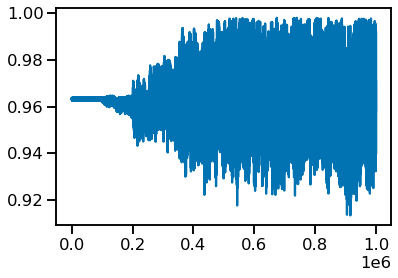

In [40]:
plt.plot(range(len(chain_hdu[1].data['a__14'])), chain_hdu[1].data['a__14'])
print(chain_hdu[1].data.dtype.names)

In [45]:
for x in chain_hdu[1].data.dtype.names:
    if 'lg10Flux' in x:
        param_err = np.percentile(chain_hdu[1].data[x][int(5e5):], q=quantiles*100).T
        flux = 10**param_err[1]
        flux_plus = 10**(param_err[2]) - flux
        flux_minus = flux - 10**(param_err[0])
        print(x + ' = ' + str(flux) + ' + ' + str(flux_plus) + ' - ' + str(flux_minus))
        print(x + ' = ' + str(flux*1.307e45) + ' + ' + str(flux_plus*1.307e45) + ' - ' + str(flux_minus*1.307e45))
        
        

lg10Flux__5 = 6.938341328653454e-10 + 1.109072415271852e-11 - 9.81336993332098e-12
lg10Flux__5 = 9.068412116550064e+35 + 1.4495576467603104e+34 - 1.282607450285052e+34
lg10Flux__91 = 2.8540138569349037e-10 + 3.719225708557303e-12 - 4.121241589947507e-12
lg10Flux__91 = 3.730196111013919e+35 + 4.861028001084395e+33 - 5.386462758061391e+33


# SS relxillNS

In [2]:
OBSID='90601340002'

products_dir = root_dir + OBSID + '_products06/'

In [3]:
chain_hdu = fits.open(products_dir + 'tbabs_diskbb_nthcomp_relxillNS_gauss_chain.out')
chain_hdu[1].data

FITS_rec([(3.88862416, 6.79973983, 0.00018487, 4.2574204 , 2.42256904, 0.01050902, 0.98196398, 24.62815103, -1.14117321, 1.29883271, 2.52082329, 0.5, 15.04502711, -0.87473781, 1.1074628 , 427.81185343),
          (3.88862416, 6.79973983, 0.00018487, 4.2574204 , 2.42256904, 0.01050902, 0.98196398, 24.62815103, -1.14117321, 1.29883271, 2.52082329, 0.5, 15.04502711, -0.87473781, 1.1074628 , 427.81185343),
          (3.88862416, 6.79973983, 0.00018487, 4.2574204 , 2.42256904, 0.01050902, 0.98196398, 24.62815103, -1.14117321, 1.29883271, 2.52082329, 0.5, 15.04502711, -0.87473781, 1.1074628 , 427.81185343),
          ...,
          (3.26510476, 6.78401234, 0.00021879, 4.61836073, 2.40606182, 0.01033243, 0.96036799, 26.26793229, -1.22754753, 1.32533028, 2.55353919, 0.5, 15.00648561, -0.76591568, 1.11274047, 438.63505886),
          (3.4163671 , 6.68171865, 0.00021465, 4.31190572, 2.34449421, 0.00938622, 0.85522844, 27.90858478, -1.28465944, 1.30462444, 2.59443202, 0.5, 15.00067545, -0.7259188

('nH__2', 'LineE__3', 'norm__5', 'norm__7', 'Gamma__8', 'norm__13', 'a__17', 'Incl__18', 'Rin__19', 'kTbb__22', 'logxi__23', 'Afe__24', 'logN__25', 'refl_frac__26', 'factor__28', 'FIT_STATISTIC')


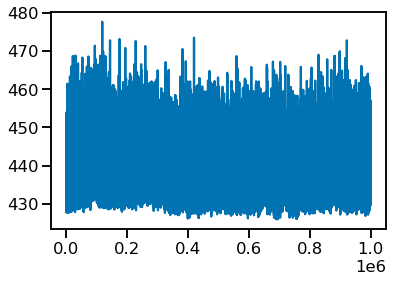

In [4]:
plt.plot(range(len(chain_hdu[1].data['FIT_STATISTIC'])), chain_hdu[1].data['FIT_STATISTIC'])
print(chain_hdu[1].data.dtype.names)

[ 3.7355705   0.95631469 25.37552805  2.15094516  1.30102434  2.53334339
  0.83394322]
3.741 + 0.5126 - 0.5452
0.966 + 0.0303 - 0.0794
25.3542 + 2.1366 - 2.0159
2.0635 + 1.0135 - 0.5973
1.3044 + 0.0272 - 0.0433
2.5357 + 0.0395 - 0.047
0.8397 + 0.0978 - 0.125


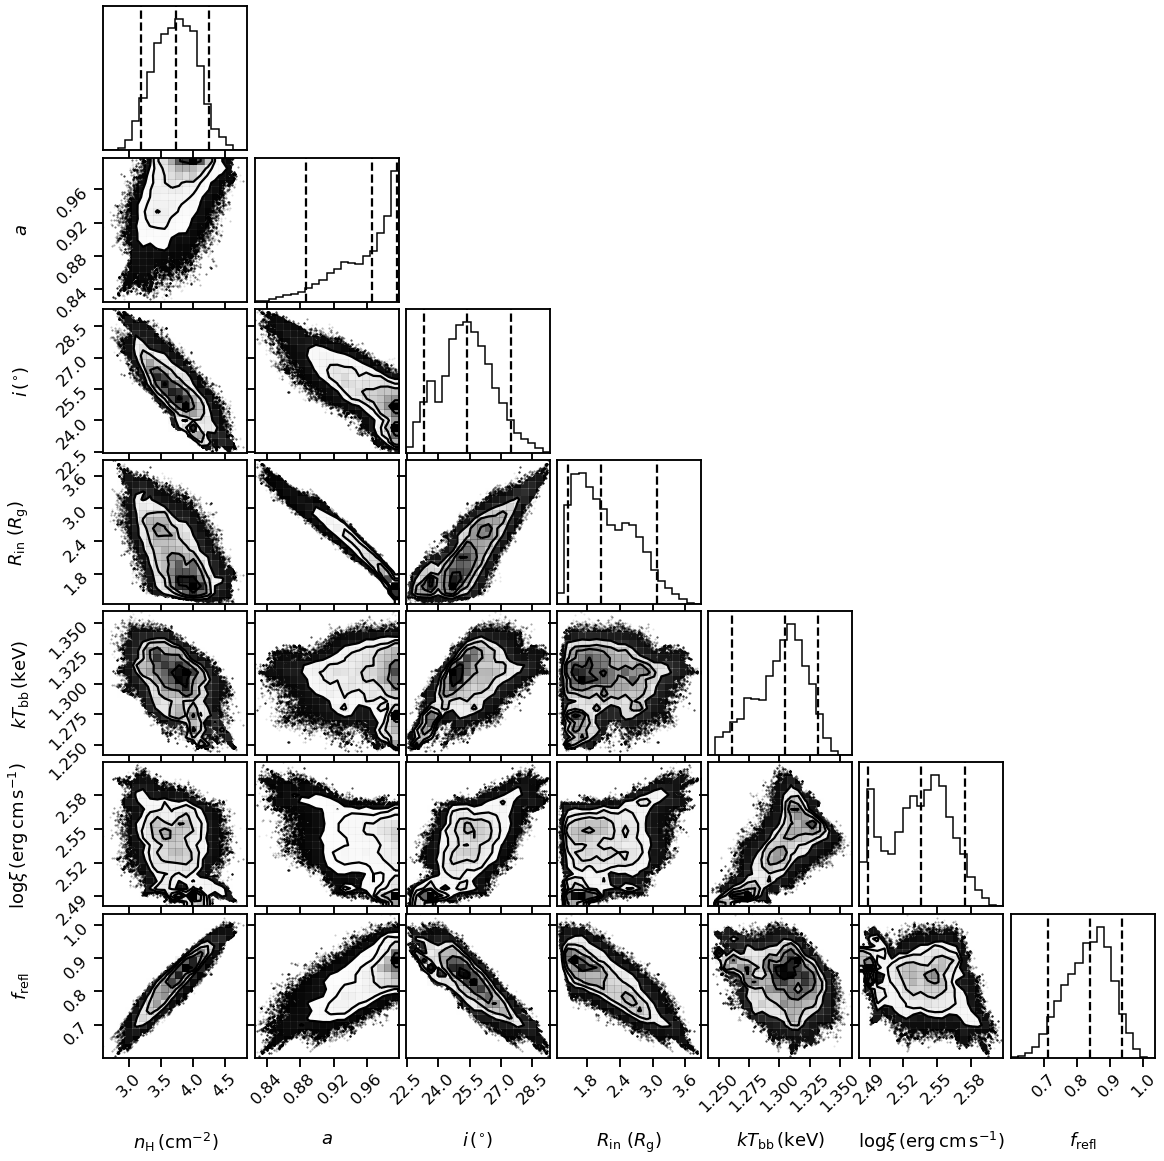

In [7]:
Z1 = 1.0 + np.power(1.0-np.square(chain_hdu[1].data['a__17']), 1/3)*(np.power(1.0+chain_hdu[1].data['a__17'], 1/3) + np.power(1.0-chain_hdu[1].data['a__17'], 1/3))
Z2 = np.sqrt(3.0*np.square(chain_hdu[1].data['a__17']) + np.square(Z1))
soft_rg = -chain_hdu[1].data['Rin__19']*(3.0 + Z2 - np.sqrt((3.0-Z1)*(3.0 + Z1 + 2.0*Z2)))

skip = ['LineE__3', 'norm__5', 'norm__7', 'Gamma__8', 'norm__13', 'factor__28', 'logN__25', 'Afe__24', 'FIT_STATISTIC']

corner_data = []
mean = []
for x in chain_hdu[1].data.dtype.names:
    if x not in skip:
        if x == 'Rin__19':
            corner_data.append(soft_rg[burn:])
            mean.append(np.mean(soft_rg[burn:]))
        elif x == 'refl_frac__26':
            corner_data.append(-chain_hdu[1].data[x][burn:])
            mean.append(np.mean(-chain_hdu[1].data[x][burn:]))
        else:
            corner_data.append(chain_hdu[1].data[x][burn:])
            mean.append(np.mean(chain_hdu[1].data[x][burn:]))
        
corner_data = np.array(corner_data)
mean = np.array(mean)

    
corner_labels=[r'$n_\mathrm{H}\,(\mathrm{cm^{-2}})$', r'$a$', r'$i\,(^{\circ})$', r'$R_{\mathrm{in}}\ (R_\mathrm{g})$', r'$kT_\mathrm{bb}\,(\mathrm{keV})$', r'$\log{\xi}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$f_\mathrm{refl}$']
# corner_labels=[r'$n_\mathrm{H}$', r'$\mu$', r'$diskbb\ norm$', r'$\Gamma$', r'$a$', r'$i$', r'$R_{\mathrm{in}}\ (R_\mathrm{g})$', r'$kT_\mathrm{bb}$', r'$\log{\chi}$', r'$\log{N}$', r'$f_\mathrm{refl}$']  

print(mean)
param_err = np.percentile(corner_data.T, q=quantiles*100, axis=0).T
for i in range(len(param_err)):
    print(str(round(param_err[i,1], 4)) + ' + ' + str(round(param_err[i,2] - param_err[i,1], 4)) + ' - ' + str(round(param_err[i,1] - param_err[i,0], 4)))
# print(param_err)
figure = corner.corner(corner_data.T, quantiles=quantiles, labels=corner_labels, labelpad=0.2, verbose=False, show_titles=False)
plt.savefig(plot_dir + 'soft_relxillNS_corner.pdf', bbox_inches='tight')

# HS Gauss

In [8]:
OBSID='90601341002'

products_dir = root_dir + OBSID + '_products06/'

In [9]:
chain_hdu = fits.open(products_dir + 'tbabs_relxilllp_gauss_chain.out')
chain_hdu[1].data

FITS_rec([(6.34459219, 6.31958604, 6.55643546e-05, 5.41589392, 0.9057775 , 26.89266032, 7.86954161, 1.59908132, 2.78376902, 0.71625906, 30.1443766 , 0.88086251, 0.00073425, 1.04577968, 410.09742485),
          (6.34459219, 6.31958604, 6.55643546e-05, 5.41589392, 0.9057775 , 26.89266032, 7.86954161, 1.59908132, 2.78376902, 0.71625906, 30.1443766 , 0.88086251, 0.00073425, 1.04577968, 410.09742485),
          (6.34459219, 6.31958604, 6.55643546e-05, 5.41589392, 0.9057775 , 26.89266032, 7.86954161, 1.59908132, 2.78376902, 0.71625906, 30.1443766 , 0.88086251, 0.00073425, 1.04577968, 410.09742485),
          ...,
          (6.44482489, 6.27096737, 5.57296272e-05, 5.21136394, 0.96262394, 28.75338547, 6.95848199, 1.55766617, 2.90974858, 0.75238845, 28.75135567, 0.87237303, 0.00071658, 1.04728739, 427.60786918),
          (7.05757515, 6.33396099, 7.70816321e-05, 5.77529218, 0.71885795, 23.88256539, 9.17610551, 1.67281772, 2.76837432, 0.65636599, 33.09163788, 0.93293976, 0.0007404 , 1.05623114, 

('nH__2', 'LineE__3', 'norm__5', 'h__6', 'a__7', 'Incl__8', 'Rin__9', 'gamma__12', 'logxi__13', 'Afe__14', 'Ecut__15', 'refl_frac__16', 'norm__18', 'factor__19', 'FIT_STATISTIC')


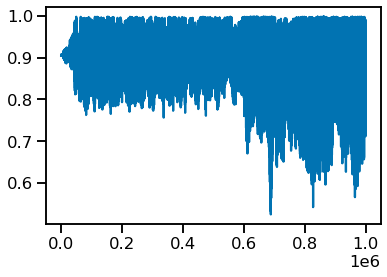

In [10]:
plt.plot(range(len(chain_hdu[1].data['a__7'])), chain_hdu[1].data['a__7'])
print(chain_hdu[1].data.dtype.names)

[ 6.41189868  5.42464782  0.89017656 26.32125192  7.92916622  2.81681155
  0.70573864  0.87128129]
6.4395 + 0.9535 - 1.046
5.3809 + 1.3564 - 1.0683
0.8993 + 0.0869 - 0.1481
26.4811 + 2.8522 - 3.4077
7.739 + 2.6275 - 1.3088
2.8001 + 0.166 - 0.0527
0.71 + 0.1306 - 0.1705
0.868 + 0.0912 - 0.0794


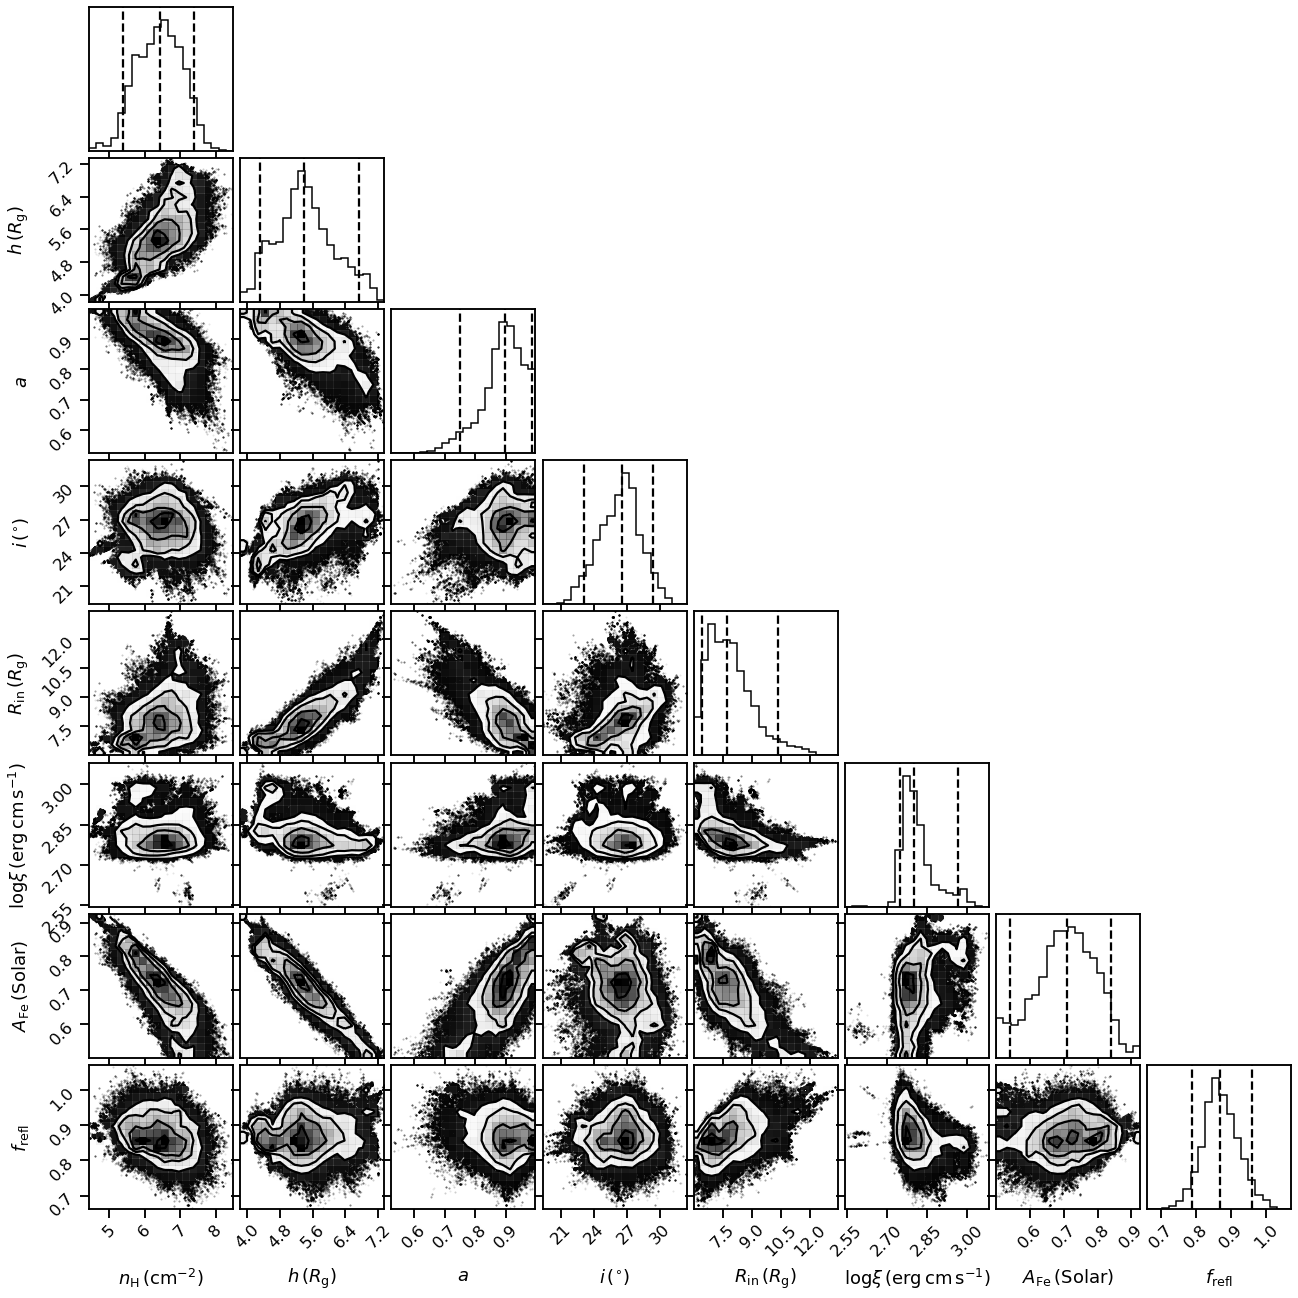

In [11]:
skip = ['LineE__3', 'norm__5', 'norm__18', 'gamma__12', 'Ecut__15', 'factor__19', 'FIT_STATISTIC']

corner_data = []
mean = []
for x in chain_hdu[1].data.dtype.names:
    if x not in skip:
        corner_data.append(chain_hdu[1].data[x][burn:])
        mean.append(np.mean(chain_hdu[1].data[x][burn:]))
        
corner_data = np.array(corner_data)
mean = np.array(mean)

    
# corner_labels=[r'$n_\mathrm{H}$', r'$\mu$', r'$h$', r'$a$', r'$i$', r'$R_{\mathrm{in}}\ (R_\mathrm{g})$', r'$\Gamma$', r'$\log{\xi}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$A_\mathrm{Fe}$', r'$E_\mathrm{cut}$', r'$f_\mathrm{refl}$']  
corner_labels=[r'$n_\mathrm{H}\,(\mathrm{cm^{-2}})$', r'$h\,(R_\mathrm{g})$', r'$a$', r'$i\,(^{\circ})$', r'$R_{\mathrm{in}}\,(R_\mathrm{g})$', r'$\log{\xi}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$A_\mathrm{Fe}\,(\mathrm{Solar})$', r'$f_\mathrm{refl}$']  

print(mean)
param_err = np.percentile(corner_data.T, q=quantiles*100, axis=0).T
for i in range(len(param_err)):
    print(str(round(param_err[i,1], 4)) + ' + ' + str(round(param_err[i,2] - param_err[i,1], 4)) + ' - ' + str(round(param_err[i,1] - param_err[i,0], 4)))
# print(param_err)
figure = corner.corner(corner_data.T, quantiles=quantiles, labels=corner_labels, labelpad=0.1, verbose=False, show_titles=False)
plt.savefig(plot_dir + 'hard_relxilllp_gauss_corner_paper.pdf', bbox_inches='tight')

# HS Xillver

In [2]:
OBSID='90601341002'

products_dir = root_dir + OBSID + '_products06/'
plot_dir = root_dir + 'figures/'

In [3]:
chain_hdu = fits.open(products_dir + 'tbabs_relxilllp_xillver_higha_chain.out')
chain_hdu[1].data

FITS_rec([(7.34662745, 1.45611118, 0.01714674, 82.23694337, -0.50263511, 0.00208199, 5.91595559, 0.95297987, 21.1902137 , 11.66361809, 1.77311016, 2.84146743, 0.54272897, 33.83615179, 0.65957217, 0.00074632, 1.04450131, 414.22859559),
          (7.54094089, 1.53784307, 0.01755539, 82.36428206, -0.47328067, 0.00189841, 5.97253273, 0.97021698, 21.62644504, 11.81834932, 1.74511969, 2.89916888, 0.55858099, 34.37575624, 0.70325118, 0.00071318, 1.03808599, 422.0599543 ),
          (7.35690219, 1.47571643, 0.01729403, 81.05841013, -0.48807678, 0.00200841, 5.73165495, 0.94749397, 21.19318483, 11.81212957, 1.78071406, 2.85028954, 0.53664648, 33.99082116, 0.67052592, 0.00076533, 1.04680463, 412.80194683),
          ...,
          (6.95630443, 1.65465437, 0.01456578, 77.78811317, -0.44080767, 0.00157555, 5.7313389 , 0.97470562, 15.63504459, 12.85010008, 1.77243306, 2.83317421, 0.55997386, 35.72397003, 0.71649806, 0.00075269, 1.05947328, 440.05445666),
          (6.82942302, 1.55650782, 0.01975422

('nH__2', 'logxi__6', 'z__7', 'Incl__8', 'refl_frac__9', 'norm__10', 'h__11', 'a__12', 'Incl__13', 'Rin__14', 'gamma__17', 'logxi__18', 'Afe__19', 'Ecut__20', 'refl_frac__21', 'norm__23', 'factor__24', 'FIT_STATISTIC')


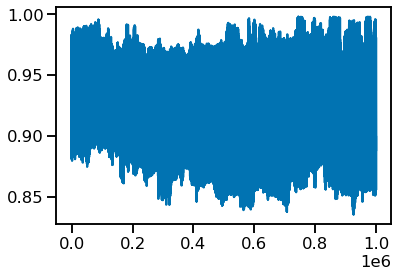

In [4]:
plt.plot(range(len(chain_hdu[1].data['a__12'])), chain_hdu[1].data['a__12'])
print(chain_hdu[1].data.dtype.names)

[7.24306969e+00 1.61325021e+00 1.79037147e-02 7.82495087e+01
 4.43269584e-01 5.45882548e+00 9.31313871e-01 2.11570219e+01
 1.23445671e+01 1.75437501e+00 2.93249579e+00 5.35835544e-01
 3.48235803e+01 7.20786314e-01]
7.2358 + 0.5107 - 0.4623
1.5475 + 0.4043 - 0.1289
0.0177 + 0.0028 - 0.0015
79.418 + 6.4319 - 10.8969
0.4528 + 0.1344 - 0.1632
5.4545 + 1.3431 - 1.2498
0.9402 + 0.035 - 0.0792
21.2195 + 2.8782 - 3.0794
12.0355 + 1.7952 - 0.6245
1.7552 + 0.0471 - 0.0498
2.9443 + 0.1111 - 0.1375
0.5317 + 0.0549 - 0.03
34.4747 + 2.4073 - 1.0024
0.6999 + 0.1524 - 0.0674


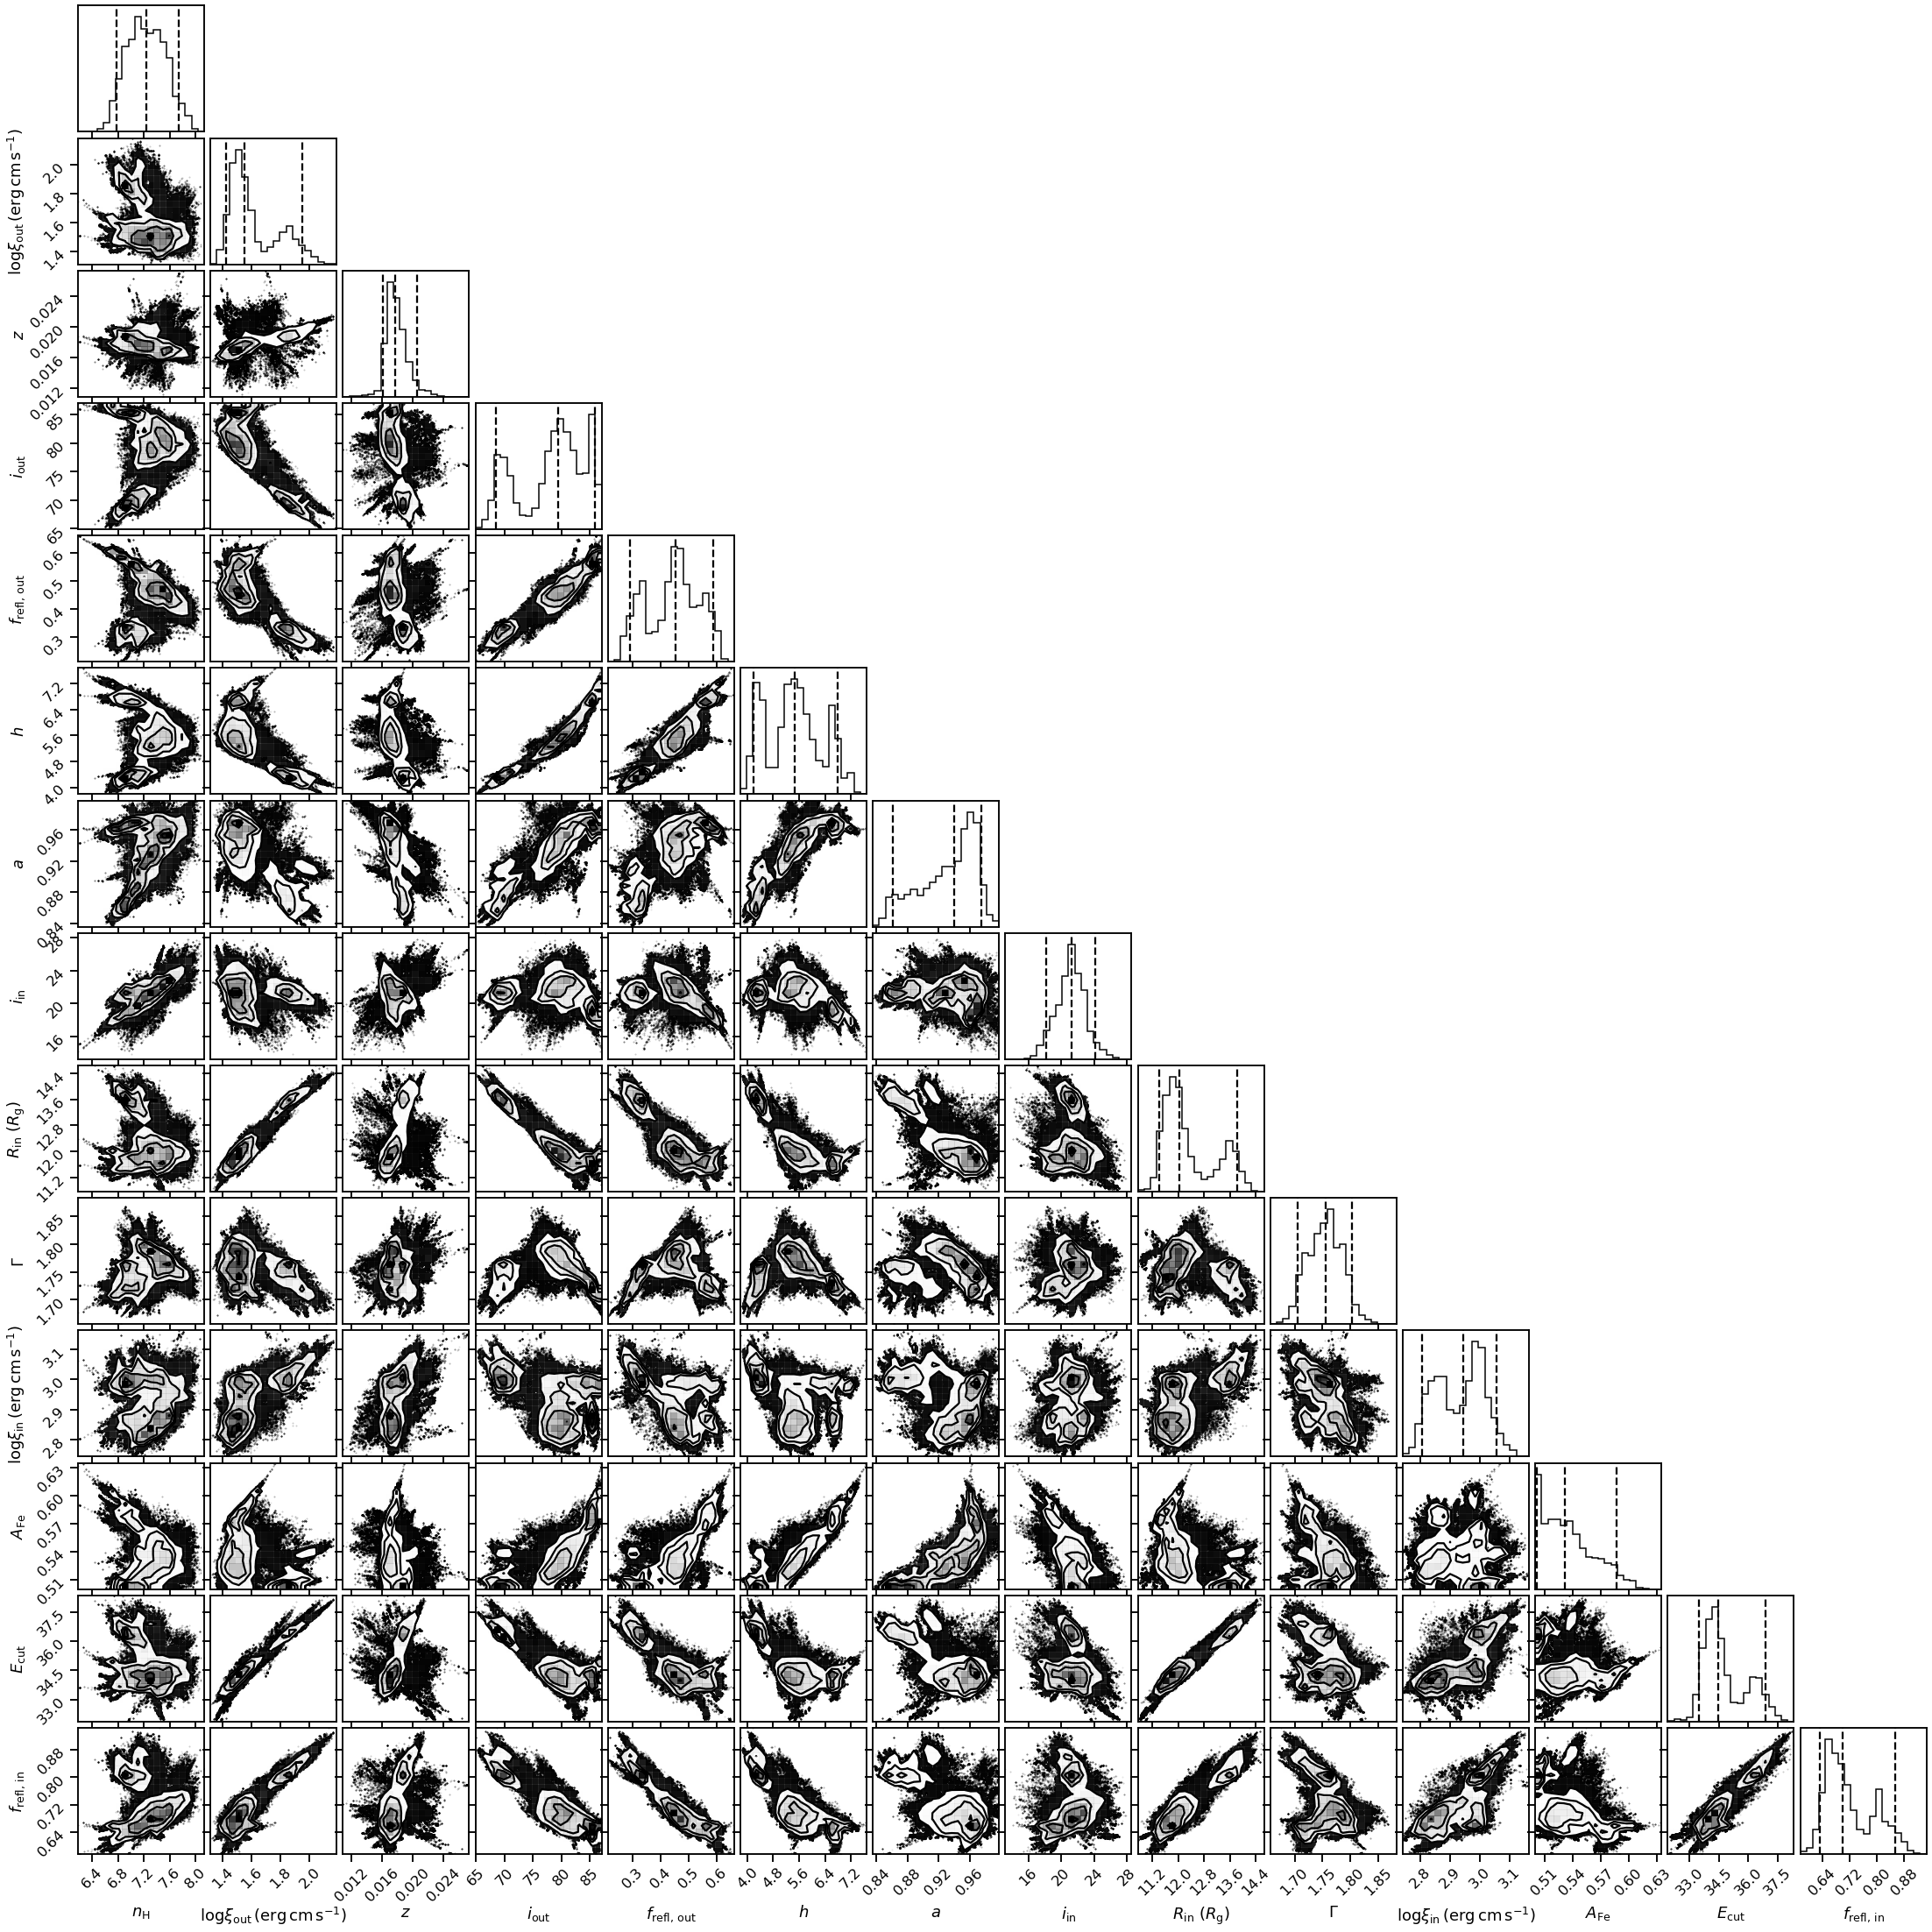

In [5]:
skip = ['norm__10', 'norm__23', 'factor__24', 'FIT_STATISTIC']

corner_data = []
mean = []
for x in chain_hdu[1].data.dtype.names:
    if x not in skip:
        if x == 'refl_frac__9':
            corner_data.append(-chain_hdu[1].data[x][burn:])
            mean.append(np.mean(-chain_hdu[1].data[x][burn:]))
        else:
            corner_data.append(chain_hdu[1].data[x][burn:])
            mean.append(np.mean(chain_hdu[1].data[x][burn:]))
        
corner_data = np.array(corner_data)
mean = np.array(mean)

    
corner_labels=[r'$n_\mathrm{H}$', r'$\log{\xi_\mathrm{out}}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$z$', r'$i_\mathrm{out}$', r'$f_\mathrm{refl,\,out}$', r'$h$', r'$a$', r'$i_\mathrm{in}$', r'$R_{\mathrm{in}}\ (R_\mathrm{g})$',  r'$\Gamma$', r'$\log{\xi_\mathrm{in}}\,(\mathrm{erg\,cm\,s^{-1}})$', r'$A_\mathrm{Fe}$', r'$E_\mathrm{cut}$', r'$f_\mathrm{refl,\,in}$']  

print(mean)
param_err = np.percentile(corner_data.T, q=quantiles*100, axis=0).T
for i in range(len(param_err)):
    print(str(round(param_err[i,1], 4)) + ' + ' + str(round(param_err[i,2] - param_err[i,1], 4)) + ' - ' + str(round(param_err[i,1] - param_err[i,0], 4)))
# print(param_err)
figure = corner.corner(corner_data.T, quantiles=quantiles, labels=corner_labels, labelpad=0.1, verbose=False, show_titles=False)
plt.savefig(plot_dir + 'hard_relxilllp_xillver_corner_paper.pdf', bbox_inches='tight')

In [60]:
for x in chain_hdu[1].data.dtype.names:
    param_err = np.percentile(chain_hdu[1].data[x][burn:], q=quantiles*100).T
    print(x + ' = ' + str(param_err[1]) + ' + ' + str(param_err[2]-param_err[1]) + ' - ' + str(param_err[1]-param_err[0]))

param_err = np.percentile(chain_hdu[1].data['Incl__8'][burn:] - chain_hdu[1].data['Incl__13'][burn:], q=quantiles*100).T
print('Delta_i = ' + str(param_err[1]) + ' + ' + str(param_err[2]-param_err[1]) + ' - ' + str(param_err[1]-param_err[0]))


nH__2 = 7.235813898849774 + 0.5107324866869023 - 0.4622749693220758
logxi__6 = 1.5474922013601808 + 0.40426751447826126 - 0.12891056351969166
z__7 = 0.017669416919273928 + 0.002845280441385354 - 0.0015267973743549532
Incl__8 = 79.41797604822251 + 6.431924443000526 - 10.89688092710152
refl_frac__9 = -0.4527698942363006 + 0.16316128262773483 - 0.13440335943894316
norm__10 = 0.0018087459020390158 + 0.0008100236164756147 - 0.0008971886779728268
h__11 = 5.454515791784428 + 1.3430789638965335 - 1.2497721826131443
a__12 = 0.9402218538504233 + 0.0349995601722245 - 0.07916998000780362
Incl__13 = 21.219519882820084 + 2.878225468837176 - 3.0794372771453205
Rin__14 = 12.03554159825065 + 1.795203190519162 - 0.624466325776087
gamma__17 = 1.7552331296549064 + 0.04707843367050679 - 0.04984447075285159
logxi__18 = 2.9442634660379596 + 0.11108480632668183 - 0.13753110699961635
Afe__19 = 0.5316723597945242 + 0.054893509760526205 - 0.030023659588929275
Ecut__20 = 34.47468307194851 + 2.4072667207187024 - 1